# TINT Demonstration


This notebook will take you through the following process:

1. GET DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import shutil
import pandas as pd
import os
import gc

import glob
import matplotlib
import cartopy.crs as ccrs


import pyart
#from tint.data_utils import get_nexrad_keys
from tint import Cell_tracks, animate
from tint.grid_utils import get_grid_alt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. GET DATA


In [2]:
import tempfile

from boto.s3.connection import S3Connection
from datetime import datetime, timedelta

def get_nexrad_keys(site, start=None, end=None):
    """
    Get generator of pyart radar objects for all nexrad data between two
    datetimes from Amazon S3.
    ----------
    site : string
        site code e.g. 'khgx'
    start : string
        datetime e.g. '20180101_000000'
    end : string
        same format as start

    """
    fmt = '%Y%m%d_%H%M%S'

    if start is None:
        start = datetime.utcnow() - timedelta(hours=1)
    else:
        start = datetime.strptime(start, fmt)
    if end is None:
        end = datetime.utcnow()
    else:
        end = datetime.strptime(end, fmt)
    if end < start:
        print('end datetime precedes start datetime')
        return

    site = site.upper()

    dates = []
    day_i = start
    while day_i < end:
        dates.append(day_i)
        day_i += timedelta(days=1)

    date_keys = [datetime.strftime(date, '%Y/%m/%d/' + site) for date in dates]

    conn = S3Connection(anon=True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    keys = [key for date_key in date_keys
            for key in list(bucket.list(date_key))
            if '.tar' not in str(key)]
    if len(keys) == 0:
        print('Found 0 files.')
        return

    # Key ealier for keys before 'V06'
    if '.gz>' in str(keys[0]):
        key_fmt = site + '%Y%m%d_%H%M%S_V06.gz>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S.gz>'
        key_fmt_3 = site + '%Y%m%d_%H%M%S_V03.gz>'
    else:
        key_fmt = site + '%Y%m%d_%H%M%S_V06>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S>'
        key_fmt_3 = site + '%Y%m%d_%H%M%S_V03>'

    key_dts = []
    key_new = []
    for key in keys:
        if 'MDM' in str(key):
            pass
        else:
            try:
                key_dts.append(datetime.strptime(str(key).split('/')[-1], key_fmt))
            except ValueError:
                try:
                    key_dts.append(
                        datetime.strptime(str(key).split('/')[-1], key_fmt_earlier))
                except:
                    key_dts.append(
                        datetime.strptime(str(key).split('/')[-1], key_fmt_3))
            key_new.append(key)
    
    key_dts = zip(key_new, key_dts)
    keys = [key for key, dt in key_dts if dt > start and dt < end]
    print('Found', len(keys), 'keys.')
    return keys
# Let's get some nexrad data from Amazon S3 to use for tracking
# I know of some storm cells that passed over Houston back in July of 2015

station = 'KENX'
keys = get_nexrad_keys(station.lower(), start='20210812_200000', end='20210812_230000')

Found 35 keys.


<Figure size 640x480 with 0 Axes>

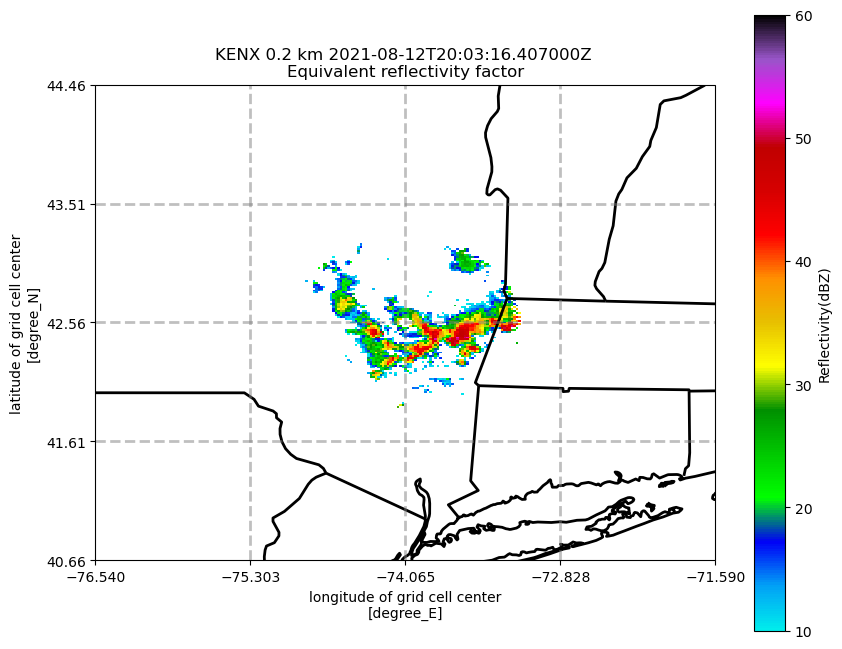

In [3]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure()
#If more than 15 keys, only look at first 15
# if(len(keys) > 15):
#     keys = keys[-10:]

def get_grid(key):
    """ Returns grid object from radar object. """
    tmp = tempfile.NamedTemporaryFile(delete=False)
    key.get_contents_to_filename(tmp.name)
    radar = pyart.io.read_nexrad_archive(tmp.name)
    loc = pyart.io.nexrad_common.get_nexrad_location(station)
    lon0 = loc[1] ; lat0 = loc[0]
    radar.longitude['data'][0] = lon0
    radar.latitude['data'][0] = lat0
    radar.range['data'] = radar.range['data']+2500
    radar.init_gate_altitude()
    radar.init_gate_longitude_latitude()
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('reflectivity',2)
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 241, 241),
        grid_limits=((0, 2000), (-200000.,200000.), (-200000., 200000.)),
        fields=['reflectivity'],gatefilters=gatefilter, gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    tmp.close()
    os.unlink(tmp.name)
    return grid, radar.longitude['data'][0], radar.latitude['data'][0]

def plot_grid(g,lat,lon,key):
    projection=ccrs.PlateCarree()
    radar_lon = lon
    radar_lat = lat
    lon = np.arange(round(radar_lon-5,2),round(radar_lon+5,2), 1)
    lat = np.arange(round(radar_lat-5,2),round(radar_lat+5,2), 1)
    
    cmap = "pyart_NWSRef"

    fig_grid = plt.figure(figsize=(10, 8))
    display = pyart.graph.GridMapDisplay(g)
    ax = fig_grid.add_subplot(111, projection=projection)
    transform = projection._as_mpl_transform(ax)
    display.plot_crosshairs(lon=radar_lon, lat=radar_lat)
    display.plot_grid('reflectivity',3,
                      vmin=10, vmax=60, mask_outside=True,
                      cmap=cmap, transform=projection, ax=ax)
    
#     Remove the comments below to save each individual image
#     plt.savefig(tmp_dir + str(key)[-23:-4] + '.png',
#                     bbox_inches = 'tight', dpi=300)
#     plt.close()
#     gc.collect()


def plot_ppi_test(key):
    """ Plots ppi map of nexrad data given S3 key. """
    g,lat,lon = get_grid(key)
    plot_grid(g,lat,lon,key)

def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    g,lat,lon = get_grid(key)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    print(name)
    filenames.append(name)
    pyart.io.write_grid(name, g)
    plot_grid(g,lat,lon,key)

if not os.path.exists("C:/Users/CoeFamily/Desktop/temporary_animation"):
    os.mkdir("C:/Users/CoeFamily/Desktop/temporary_animation")
tmp_dir = "C:/Users/CoeFamily/Desktop/temporary_animation"
plot_ppi_test(keys[0])
plt.show()

## 2. GRID

### Disclaimer
If you are running this notebook and don't want this data to remain on your filesystem, make sure you run the last cell in the notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [4]:
# Let's make a function that maps these volumes to cartesian grids using pyart.

filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    plot_ppi(key)
    gc.collect

saving grid 0
C:/Users/CoeFamily/Desktop/temporary_animation\grid_000.nc
saving grid 1
C:/Users/CoeFamily/Desktop/temporary_animation\grid_001.nc
saving grid 2
C:/Users/CoeFamily/Desktop/temporary_animation\grid_002.nc
saving grid 3
C:/Users/CoeFamily/Desktop/temporary_animation\grid_003.nc
saving grid 4
C:/Users/CoeFamily/Desktop/temporary_animation\grid_004.nc
saving grid 5
C:/Users/CoeFamily/Desktop/temporary_animation\grid_005.nc
saving grid 6
C:/Users/CoeFamily/Desktop/temporary_animation\grid_006.nc
saving grid 7
C:/Users/CoeFamily/Desktop/temporary_animation\grid_007.nc
saving grid 8
C:/Users/CoeFamily/Desktop/temporary_animation\grid_008.nc
saving grid 9
C:/Users/CoeFamily/Desktop/temporary_animation\grid_009.nc
saving grid 10
C:/Users/CoeFamily/Desktop/temporary_animation\grid_010.nc
saving grid 11
C:/Users/CoeFamily/Desktop/temporary_animation\grid_011.nc
saving grid 12
C:/Users/CoeFamily/Desktop/temporary_animation\grid_012.nc
saving grid 13
C:/Users/CoeFamily/Desktop/tempor

In [5]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [6]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000,
 'FLOW_MARGIN': 10000,
 'MAX_FLOW_MAG': 50,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 15,
 'ISO_THRESH': 6,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500}

In [7]:
# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 6
tracks_obj.params['MAX_SHIFT_DISP'] = 10
# We can change this parameter to find cells above a certain dBz threshold
tracks_obj.params['FIELD_THRESH'] = 20
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20
Writing tracks for scan 21
Writing tracks for scan 22
Writing tracks for scan 23
Writing tracks for scan 24
Writing tracks for scan 25
Writing tracks for scan 26
Writing tracks for scan 27
Writing tracks for scan 28
Writing tracks for scan 29
Writing tracks for scan 30
Writing tracks for scan 31
Writing tracks for scan 32
Writing tracks for scan 33
Writing tracks for scan 34


time elapsed 0.4 minutes


In [8]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks.head(20)

time   grid_x   grid_y      lon      lat  \
scan uid                                                               
0    0   2021-08-12 20:03:16.407   72.973   24.882 -75.0000  41.1586   
     1   2021-08-12 20:03:16.407   88.125   33.375 -74.7026  41.2806   
     2   2021-08-12 20:03:16.407   99.042   35.625 -74.4836  41.3266   
     3   2021-08-12 20:03:16.407   69.708   41.208 -75.0635  41.3979   
     4   2021-08-12 20:03:16.407  106.286   39.571 -74.3441  41.3870   
     5   2021-08-12 20:03:16.407  118.067   44.400 -74.1044  41.4472   
     6   2021-08-12 20:03:16.407   41.625   64.877 -75.6316  41.7512   
     7   2021-08-12 20:03:16.407  120.250   47.750 -74.0644  41.5072   
     8   2021-08-12 20:03:16.407  130.938   51.406 -73.8441  41.5520   
     9   2021-08-12 20:03:16.407   40.800   77.200 -75.6561  41.9308   
     10  2021-08-12 20:03:16.407  117.286   75.571 -74.1249  41.9269   
     11  2021-08-12 20:03:16.407  146.273   77.455 -73.5405  41.9407   
     12  2021-08-12 20:03:16.407   28.100   85.000 -75.9215  42.0467   
     13  2021-08-12 20:03:16.407  137.667   86.667 -73.7009  42.0912   
     14  2021-08-12 20:03:16.407   25.364   89.091 -75.9839  42.1056   
     15  2021-08-12 20:03:16.407  137.200   89.400 -73.7209  42.1212   
     16  2021-08-12 20:03:16.407  136.548  121.155 -73.7183  42.6009   
     17  2021-08-12 20:03:16.407  115.800   92.800 -74.1453  42.1817   
     18  2021-08-12 20:03:16.407  142.692   98.462 -73.5987  42.2557   
     19  2021-08-12 20:03:16.407    1.909  100.273 -76.4546  42.2617   

                 area          vol        max  max_alt  isolated  
scan uid                                                          
0    0    1322.222222   588.703704  53.577385      2.0     False  
     1      44.444444    25.185185  39.002697      2.0     False  
     2      66.666667    62.962963  50.500000      2.0      True  
     3      66.666667    48.703704  26.240496      2.0     False  
     4      19.444444    15.185185  31.000000      2.0      True  
     5      41.666667    33.703704  40.750004      2.0     False  
     6     747.222222   604.259259  31.939686      2.0     False  
     7      11.111111     5.555556  25.000000      2.0     False  
     8      88.888889   112.962963  53.749477      2.0      True  
     9      27.777778    16.111111  22.258980      2.0     False  
     10     19.444444    26.481481  36.162022      2.0      True  
     11     30.555556    37.407407  30.407965      2.0      True  
     12     27.777778    12.222222  27.249899      2.0     False  
     13      8.333333     2.407407  23.466253      2.0     False  
     14     30.555556    11.481481  24.333494      2.0     False  
     15     13.888889     7.037037  29.268919      2.0     False  
     16   4958.333333  7617.592593  57.000000      2.0     False  
     17     13.888889     8.888889  32.419800      2.0     False  
     18     36.111111    50.740741  50.718121      2.0     False  
     19     30.555556     2.777778  23.000000      2.0     False

In [9]:
tracks_obj.tracks.groupby(level='uid').get_group('0')[['lat','lon']]
pointA = (tracks_obj.tracks.groupby(level='uid').get_group('0')['lat'][0],tracks_obj.tracks.groupby(level='uid').get_group('0')['lon'][0])
#pointA
tracks_obj.tracks.groupby(level='uid').get_group('0')['lat'].values

array([41.1586, 41.1442, 41.1448, 41.1152, 41.071 , 41.0711, 41.1014,
       41.1165, 41.1615])

## 4. VISUALIZE

In [10]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

Animating 35 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24
Frame: 25
Frame: 26
Frame: 27
Frame: 28
Frame: 29
Frame: 30
Frame: 31
Frame: 32
Frame: 33
Frame: 34


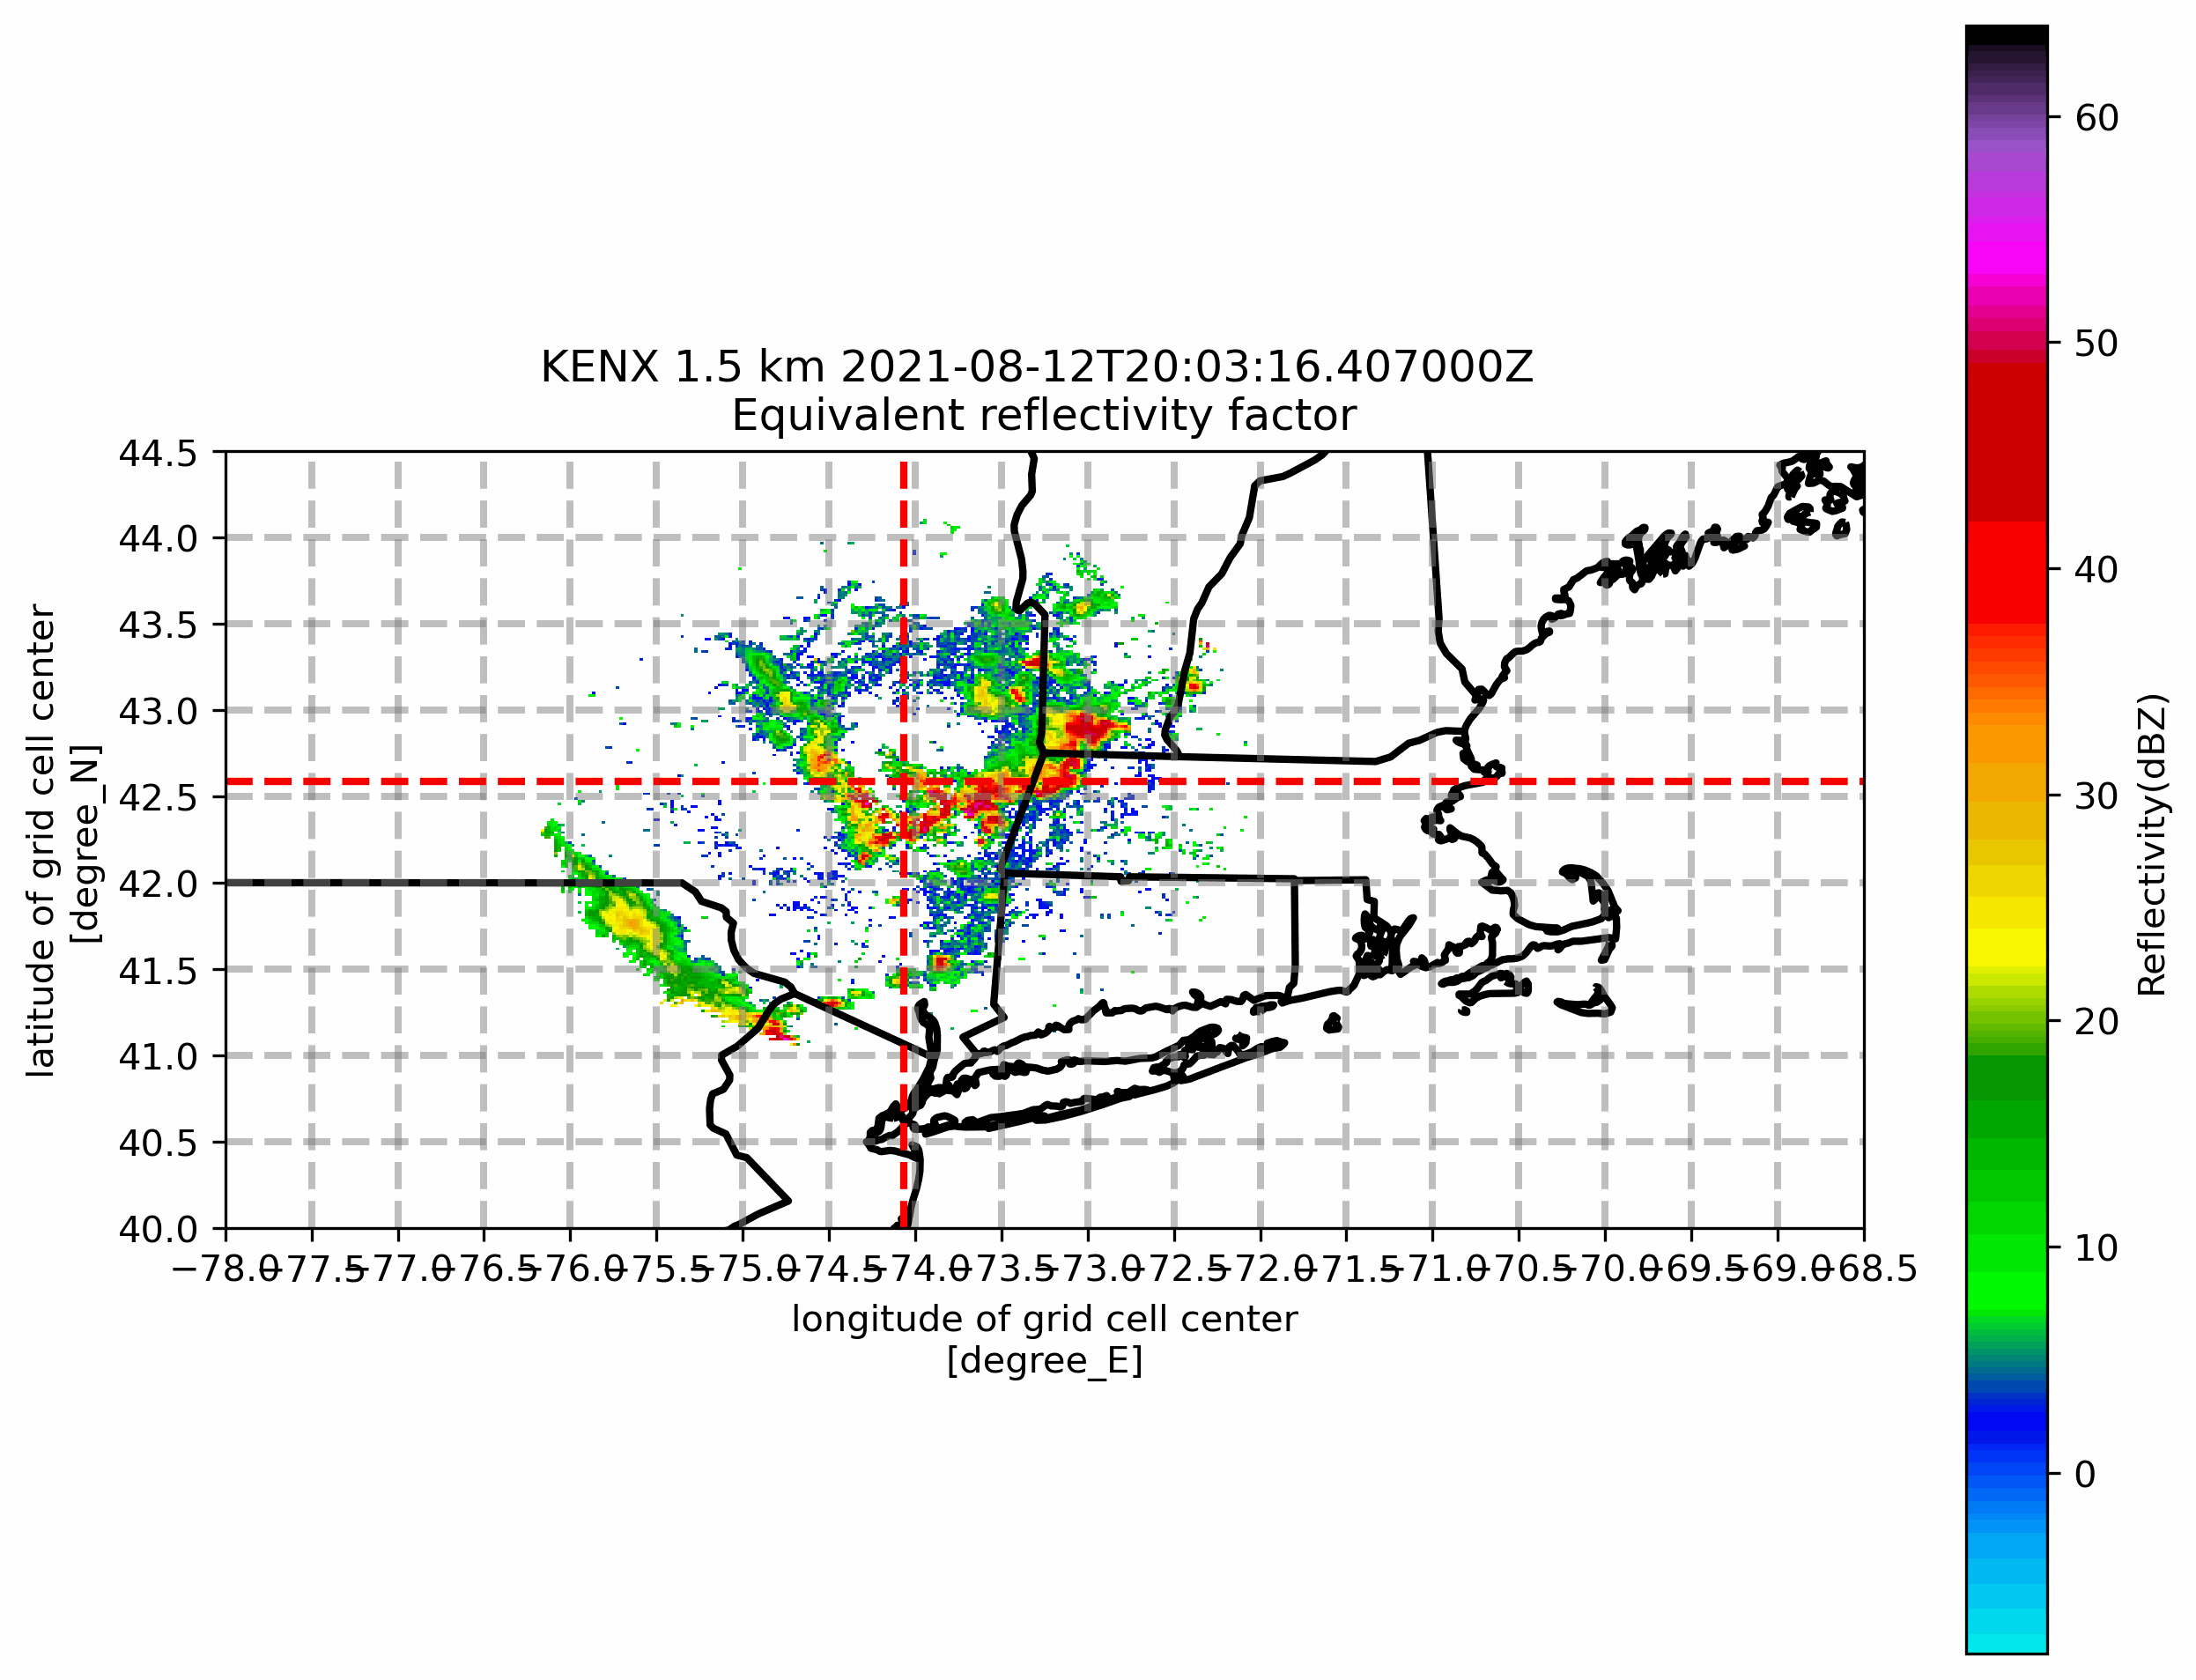

In [11]:
# Let's save the animation in our temp directory so that it will be cleaned up later and then open it.
fname = animate(tracks_obj, grids, tmp_dir,os.path.join(tmp_dir, 'tint_demo_anim200'),
        lat_lines=np.arange(40, 45, .5),
        lon_lines=np.arange(-78, -68, .5),
        tracers=True,cmap='pyart_NWSRef')
Image(open(fname,'rb').read())

In [12]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

uid
8      19
35     18
139    18
38     16
101    16
       ..
238     1
239     1
24      1
240     1
99      1
Length: 344, dtype: int64

In [ ]:
# Now we can view these cells from a lagrangian perspective
grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='0', alt=2000)

In [ ]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

In [ ]:
import math

def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [ ]:
# We can view the attributes of this cell throughout its lifetime
# For each cell, compute the average direction of motion

coordinates = []
for group in tracks_obj.tracks.groupby(level='uid').groups:
    temp = tracks_obj.tracks.groupby(level='uid').get_group(group) 
    lats = temp['lat']
    lons = temp['lon']
    if (len(lats) <=2 or len(lons) <=2):
        pass
    elif(len(lats) != len(lons) ):
        pass
    else:
        temp_coords = []
        for i in range(len(lats)-1):
            pointA = (lats[i],lons[i])
            pointB = (lats[i+1],lons[i+1])
            temp_direction = calculate_initial_compass_bearing(pointA, pointB)
            if temp_direction % 90 == 0:
                pass
            else:
                temp_coords.append(temp_direction)
        print(temp_coords)
        print(np.mean(temp_coords) - np.std(temp_coords))
        coordinates.append((group,np.mean(temp_coords),np.mean(temp_coords)+180))
        
coordinates

In [ ]:
df = pd.DataFrame(coordinates,columns=['Cell','Direction To','Direction From'])
df.to_csv('/mnt/c/Users/CoeFamily/Documents/12222008.csv',index=False)

## Clean Up

In [ ]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')

In [ ]:
df.mean()